In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import numpy as np

Training Data: 'combined_text' concatinates title and abstract arrays.

In [2]:
traindf = pd.read_csv('./Data/train.csv')
traindf['abstract'] = traindf['abstract'].apply(lambda abstract: abstract.strip('[]').split(', '))
traindf['title'] = traindf['title'].apply(lambda title: title.strip('[]').split(', '))
traindf['authors'] = traindf['authors'].apply(lambda authors: authors.strip('[]').split(', '))
traindf['combined_text'] = traindf.title+traindf.abstract

Word2vec embedding: All encoded words in training data (abstract and title) converted to an 600 dimensinal embedding.

In [3]:
import gensim

C:\Users\pavit\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
modelSG = gensim.models.Word2Vec(traindf['combined_text'], min_count = 1, vector_size = 600, window = 5, sg = 1)

Training labels: For each article an array of 0 or 1 indicating whether author $i \in {0,...,99}$ is a target label.

In [5]:
def targetLabels(authorData):
    labels = np.zeros((len(authorData), 100))
    for i, article in enumerate(authorData):
        for j, author in enumerate(article):
            author = int(author)
            if author < 100:
                labels[i][author] = 1
    return labels

Functions for converting coauthors (non-prolific) for an article to vectors (i-th element of j-th vector is 1 if i-th coauthor contributed to j-th article), and for converting words in each article to the embeddings.

In [6]:
def coauthorsToVectors(authorData, n_authors):
    coauths = np.zeros((len(authorData), n_authors))
    for i, article in enumerate(authorData):
        for j, author in enumerate(article):
            author = int(author)
            if author >= 100:
                coauths[i][author] = 1
    return coauths

def embedLine(embedding, line):
    arr = []
    for li, word in enumerate(line):
        try:
            arr.append(embedding[word])
        except:
            continue
    return arr


GRU with attention:

In [18]:
class AttentionGRUClassifier(nn.Module):
    def __init__(self, embed_size, n_authors, hidden_size, text_output_size, coauth_output_size, output_size):
        super(AttentionGRUClassifier, self).__init__()
        self.gru = nn.GRU(embed_size, hidden_size)
        self.text_layer = nn.Linear(hidden_size, text_output_size)
        self.att = nn.Linear(hidden_size, 1)
        self.coauth_layer = nn.Linear(n_authors, coauth_output_size)
        self.final = nn.Linear(text_output_size+coauth_output_size, output_size)
        
    def forward(self, input_words, input_coauthors):
        # Process text (abstract/title) into RNN hidden state sequence
        states, _ = self.gru(input_words)
        # Attention scores for each hidden state
        att_scores = self.att(states)
        # Rescale attention with softmax
        alpha = F.log_softmax(att_scores, dim=0)
        # Compute weighted sum of hidden states
        c = torch.sum(torch.mul(states, alpha), dim=0)
        # Compute output, and apply log-softmax
        text_output = F.relu(self.text_layer(c.view(1, -1)))
        coauth_output = F.relu(self.coauth_layer(input_coauthors.view(1,-1)))
        combined_output = torch.cat((text_output, coauth_output), dim=1).view(1,-1)
        output = self.final(combined_output)
        output = F.sigmoid(output)
        return output

In [11]:
train_text = np.array([embedLine(modelSG.wv, traindf.combined_text[i]) for i in range(traindf.shape[0])], dtype=object)
train_labels = torch.tensor(targetLabels(traindf.authors)).view(-1,1,100).to(torch.float32)
train_coauthors = torch.tensor(coauthorsToVectors(traindf.authors, 21246)).view(-1,1,21246).to(torch.float32)

Subset of training data with prolific authors:

In [26]:
train_prolific_ids = np.array([i for i,labels in enumerate(train_labels) if (torch.sum(labels) > 0)])

In [33]:
embed_size = 600
hidden_size = 200
text_output_size = 100
n_authors = 21246
coauth_output_size = 100
output_size = 100

model = AttentionGRUClassifier(embed_size, n_authors, hidden_size, text_output_size, coauth_output_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

n_epochs = 6
n_samples = len(train_prolific_ids)
print_every = 5000
plot_every = 500

start = time.time()
all_losses = []
current_loss = 0
iter_count = 0
all_epoch_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

model.train()

for epoch in range(n_epochs):
    epoch_loss = 0
    for sample_id in random.sample(list(train_prolific_ids), n_samples):
        iter_count += 1
        text_tensor = torch.tensor(train_text[sample_id]).view(-1, 1, 600)
        label_tensor = train_labels[sample_id]
        coauthor_tensor = train_coauthors[sample_id]

        model.zero_grad()
        output = model.forward(text_tensor, coauthor_tensor)
        output = torch.squeeze(output, 1) # remove redundant dimension
        loss = criterion(output, label_tensor)
        current_loss += loss.item()
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if iter_count % print_every == 0:
            print('epoch: %d, total iterations: %d, progress: %d%% (%s), loss: %.4f' % (epoch, iter_count, iter_count / (n_epochs*n_samples) * 100, timeSince(start), loss))
            
        if iter_count % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    all_epoch_losses.append(epoch_loss)

epoch: 0, total iterations: 5000, progress: 11% (5m 57s), loss: 0.0907
epoch: 1, total iterations: 10000, progress: 22% (11m 36s), loss: 0.1899
epoch: 2, total iterations: 15000, progress: 33% (17m 2s), loss: 0.0719
epoch: 2, total iterations: 20000, progress: 44% (22m 30s), loss: 0.0919
epoch: 3, total iterations: 25000, progress: 55% (27m 57s), loss: 0.0805
epoch: 4, total iterations: 30000, progress: 67% (33m 20s), loss: 0.0336
epoch: 4, total iterations: 35000, progress: 78% (38m 42s), loss: 0.0745
epoch: 5, total iterations: 40000, progress: 89% (44m 7s), loss: 0.0622


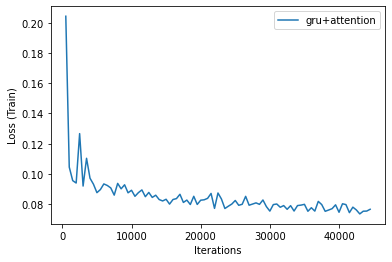

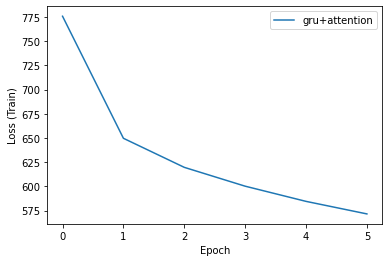

In [34]:
plt.figure()
plt.plot(range(plot_every,n_epochs*n_samples,plot_every),all_losses, label='gru+attention')
plt.xlabel('Iterations')
plt.ylabel('Loss (Train)')
plt.legend()

plt.figure()
plt.plot(range(0, n_epochs, 1),all_epoch_losses, label='gru+attention')
plt.xlabel('Epoch')
plt.ylabel('Loss (Train)')
plt.legend()